# Poleward Heat Transport

`mom6_tools.polar_heat_transport` collection of functions for computing and plotting poleward heat transport.

The goal of this notebook is the following:

1) server as an example on to compute polar heat transport from CESM/MOM output; 

2) evaluate model experiments by comparing transports against observed estimates;

3) compare model results vs. another model results (TODO).

In [7]:
%matplotlib inline
from mom6_tools.poleward_heat_transport import  *
from mom6_tools.m6toolbox import genBasinMasks
from mom6_tools.DiagsCase import DiagsCase
import mom6_tools.m6toolbox

from datetime import datetime, date
import yaml
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import xarray as xr
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read in the yaml file
diag_config_yml_path = "diag_config.yml"
diag_config_yml = yaml.load(open(diag_config_yml_path,'r'), Loader=yaml.Loader)

In [3]:
# Create the case instance
dcase = DiagsCase(diag_config_yml['Case'])
RUNDIR = dcase.get_value('RUNDIR')
print('Run directory is:', RUNDIR)
print('Casename is:', dcase.casename)

Run directory is: /glade/scratch/gmarques/g.c2b6.GJRA.TL319_t061.long_JRA_mct.025/run
Casename is: g.c2b6.GJRA.TL319_t061.long_JRA_mct.025


In [18]:
# create an empty class object
class args:
  pass

args.case_name = dcase.casename
args.start_date = ''
args.end_date = ''
args.savefigs = False

In [19]:
# set avg dates
avg = diag_config_yml['Avg']
if not args.start_date : args.start_date = avg['start_date']
if not args.end_date : args.end_date = avg['end_date']

In [6]:
# Load the grid
grd = dcase.grid
depth = grd.depth_ocean
# remove Nan's, otherwise genBasinMasks won't work
depth[np.isnan(depth)] = 0.0
basin_code = genBasinMasks(grd.geolon, grd.geolat, depth, verbose=False)

MOM6 grid successfully loaded... 

11.16427964664149 64.78854837178643 [391, 434]


In [8]:
parallel, cluster, client = m6toolbox.request_workers(6)

Requesting 6 workers... 

/proxy/8787/status


In [10]:
client

Client Scheduler: tcp://128.117.181.218:46497 Dashboard: /proxy/8787/status,Cluster Workers: 6 Cores: 6 Memory: 150.00 GB


In [11]:
def preprocess(ds):
    ''' Compute montly averages and return the dataset with variables'''
    ds
    for var in variables:
      print('Processing {}'.format(var))
      if var not in ds.variables:
        print('WARNING: ds does not have variable {}. Creating dataarray with zeros'.format(var))
        jm, im = grd.geolat.shape
        tm = len(ds.time)
        da = xr.DataArray(numpy.zeros((tm, jm, im)), dims=['time', 'yq','xh'], \
             coords={'yq' : grd.yq, 'xh' : grd.xh, 'time' : ds.time}).rename(var)
        ds = xr.merge([ds, da])
    return ds[variables].resample(time="1Y", closed='left', \
           keep_attrs=True).mean(dim='time', keep_attrs=True)

In [12]:
print('\n Reading monthly (hm_*) dataset...')
# load data
variables = ['T_ady_2d', 'T_diffy_2d', 'T_lbd_diffy_2d']

%time ds = xr.open_mfdataset(RUNDIR+'/'+dcase.casename+'.mom6.hm_*.nc', \
         parallel=True, data_vars='minimal', chunks={'time': 12},\
         coords='minimal', compat='override', preprocess=preprocess)


 Reading monthly (hm_*) dataset...
CPU times: user 3.99 s, sys: 24.5 s, total: 28.5 s
Wall time: 58.3 s


In [13]:
print('\n Selecting data between {} and {}...'.format(args.start_date, args.end_date))
%time ds_sel = ds.sel(time=slice(args.start_date, args.end_date)).load()


 Selecting data between 0029-01-01 and 0059-01-01...
CPU times: user 354 ms, sys: 250 ms, total: 604 ms
Wall time: 2.21 s


In [14]:
print('\n Computing time mean...')
%time ds_sel = ds_sel.mean('time').load()


 Computing time mean...
CPU times: user 130 ms, sys: 117 ms, total: 248 ms
Wall time: 233 ms


In [15]:
# release workers
client.close(); cluster.close()

In [22]:
stream = True
# create a ndarray subclass
class C(np.ndarray): pass

varName = 'T_ady_2d'
if varName in ds.variables:
  tmp = np.ma.masked_invalid(ds_sel[varName].values)
  tmp = tmp[:].filled(0.)
  advective = tmp.view(C)
  advective.units = ds[varName].units
else:
  raise Exception('Could not find "T_ady_2d" in ds')

varName = 'T_diffy_2d'
if varName in ds.variables:
  tmp = np.ma.masked_invalid(ds_sel[varName].values)
  tmp = tmp[:].filled(0.)
  diffusive = tmp.view(C)
  diffusive.units = ds[varName].units
else:
  diffusive = None
  warnings.warn('Diffusive temperature term not found. This will result in an underestimation of the heat transport.')

    
varName = 'T_lbd_diffy_2d'
if varName in ds.variables:
  tmp = numpy.ma.masked_invalid(ds_sel[varName].values)
  tmp = tmp[:].filled(0.)
  lbd = tmp.view(C)
  #lbd.units = ds[varName].units
else:
  lbd = None
  warnings.warn('Lateral boundary mixing term not found. This will result in an underestimation of the heat transport.')

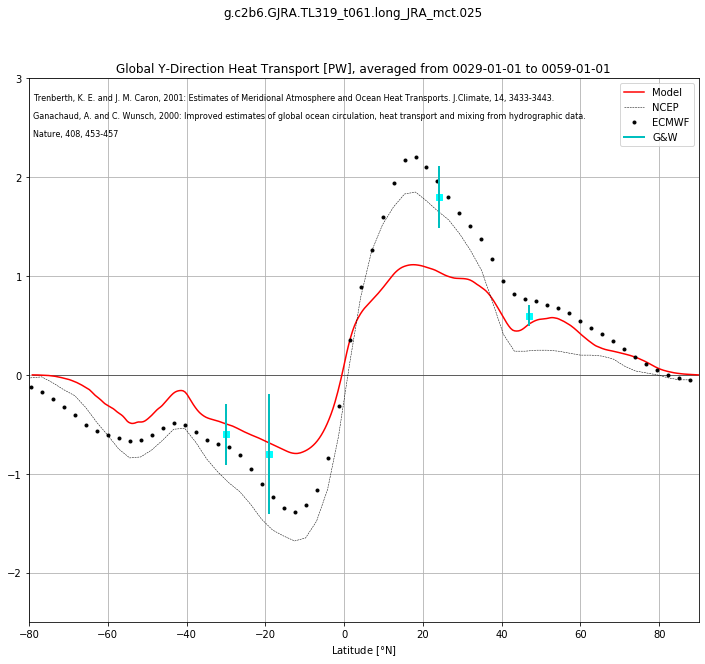

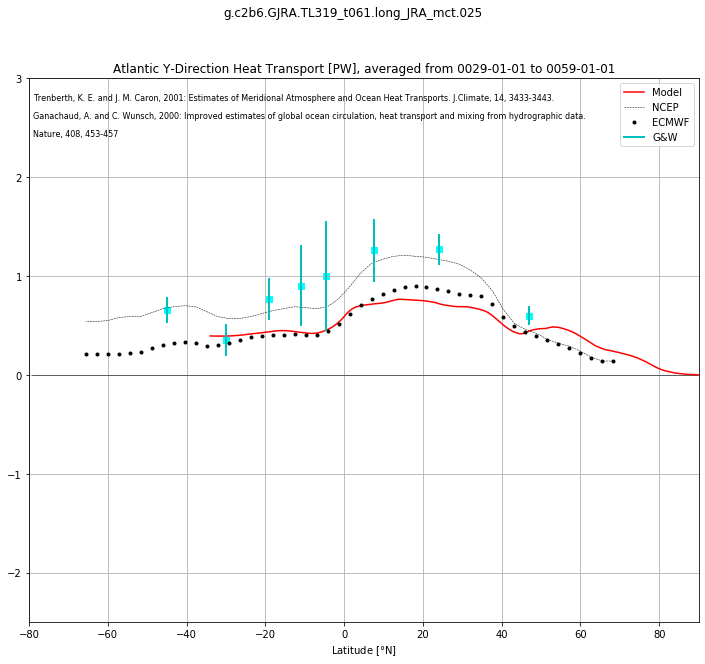

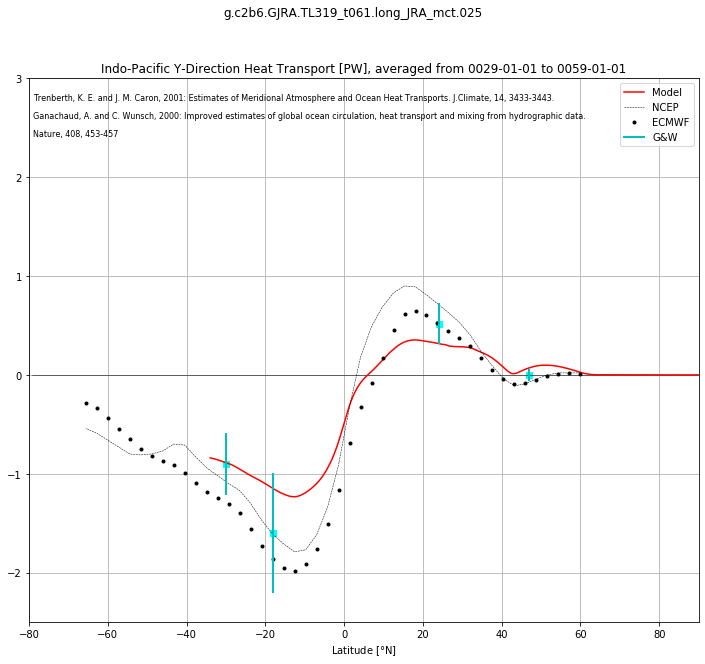

In [23]:
%matplotlib inline
# plot model vs obs
plt_heat_transport_model_vs_obs(advective, diffusive, lbd, basin_code, grd, args)  